In [4]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [5]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [6]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, text

In [7]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [8]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with = engine)

In [9]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date

('2017-08-23',)

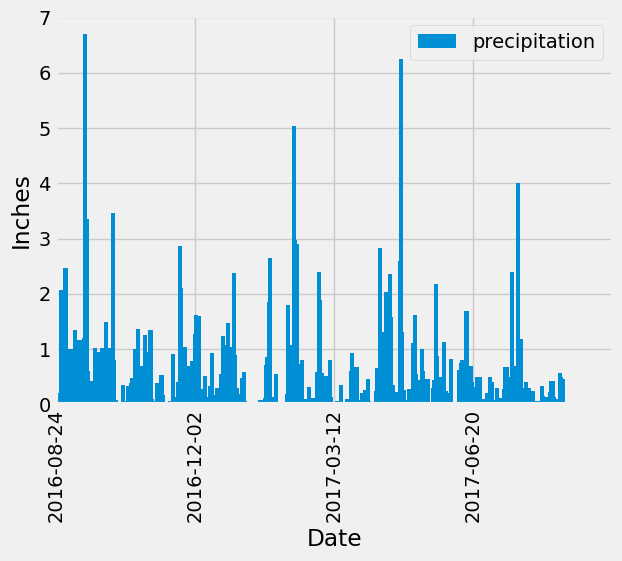

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date
# Calculate the date one year from the last date in data set.
last_12_months = dt.datetime.strptime(most_recent_date[0], '%Y-%m-%d') - dt.timedelta(days = 365)

# Perform a query to retrieve the data and precipitation scores
last_12_months_data = session.query(Measurement.station,Measurement.date,Measurement.prcp,Measurement.tobs).\
    filter(Measurement.date > last_12_months).\
    filter(Measurement.date <= most_recent_date[0]).\
    all()
# Save the query results as a Pandas DataFrame. Explicitly set the column names
last_12_months_df = pd.DataFrame(last_12_months_data)

# Sort the dataframe by date
last_12_months_df = last_12_months_df.sort_values(by = 'date').dropna()
# Use Pandas Plotting with Matplotlib to plot the data
x = np.arange(0,len(last_12_months_df))
x_ticks = last_12_months_df['date'].tolist()
plt.bar(last_12_months_df['date'],last_12_months_df['prcp'],width = 3)
plt.xticks(np.arange(0, len(x), step = 100), rotation = 'vertical')
plt.xlim(0,400)
plt.ylabel("Inches")
plt.legend(["precipitation"])
plt.xlabel("Date")
plt.show()

In [14]:
# Use Pandas to calculate the summary statistics for the precipitation data
last_12_months_df = last_12_months_df.rename(columns= {'prcp':'precipitation'})
last_12_months_df_sum_stat = last_12_months_df['precipitation'].describe()
last_12_months_df_sum_stat

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64

# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number of stations in the dataset
total_station = session.query(Measurement.station).distinct().count()
print(total_station)

9


In [16]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_act_count = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).\
    all()
station_act_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
conn = engine.connect()
columns = conn.execute(text('select * from measurement'))
columns = columns.keys()
columns

RMKeyView(['id', 'station', 'date', 'prcp', 'tobs'])

In [18]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
stat_most_act_station = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == station_act_count[0][0]).\
    all()

stat_most_act_station

[(54.0, 85.0, 71.66378066378067)]

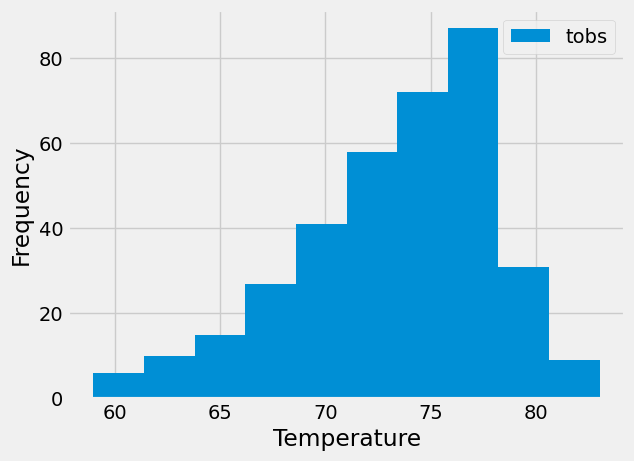

In [19]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
latest_date = session.query(Measurement.date).\
    order_by(Measurement.date.desc()).\
    filter(Measurement.station == station_act_count[0][0]).\
    first()

station_last_12_months = dt.datetime.strptime(latest_date[0], '%Y-%m-%d') - dt.timedelta(days = 365)

station_last_12_months_data = session.query(Measurement.station,Measurement.date,Measurement.tobs).\
    filter(Measurement.date > station_last_12_months).\
    filter(Measurement.date <= latest_date[0]).\
    filter(Measurement.station == station_act_count[0][0]).\
    all()

station_last_12_months_df = pd.DataFrame(station_last_12_months_data)

plt.hist(station_last_12_months_df['tobs'])
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend(['tobs'])
plt.show()


# Close Session

In [21]:
# Close Session
session.close()